In [1]:
!pip install ipython-autotime
%load_ext autotime
!pip install transformers
!pip install -U accelerate
!pip install -U datasets
!pip install seqeval
!pip install evaluate
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=809062b66a45faf4bcc1f1076bca7594fefe2f0f7891210e56326d717506be05
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00
time: 37.1 s (started: 202

In [2]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

time: 379 µs (started: 2023-12-16 20:16:22 +00:00)


In [3]:
import pandas as pd
import torch
import numpy as np
import re
import json
import copy
import random
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from transformers import Trainer, T5Tokenizer, AdamW, T5ForConditionalGeneration, TrainingArguments, EvalPrediction, AutoTokenizer
from datasets import Dataset, DatasetDict, ClassLabel

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

time: 9.58 s (started: 2023-12-16 20:16:22 +00:00)


In [4]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

time: 4.21 s (started: 2023-12-16 20:16:31 +00:00)


In [5]:
print(tokenizer.is_fast)

True
time: 636 µs (started: 2023-12-16 20:16:35 +00:00)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

time: 286 ms (started: 2023-12-16 20:16:35 +00:00)


**Adding Special Tokens**
We are using T5 model, so we need to add our newly introducez tokens to model's vocabulary. Also, since T5 model does not use SEP, we need to add it as well.

In [7]:
# Add a new special token
num_added_special_tokend = tokenizer.add_special_tokens({'additional_special_tokens': ['[TTAG]', '[SEP]' ]})
print(num_added_special_tokend)

# Resize the token embeddings in the model
model.resize_token_embeddings(len(tokenizer))

# Verify the updated special tokens
print("Updated Special Tokens:")
special_tokens = tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)
print(special_tokens)


2
Updated Special Tokens:
['</s>', '<unk>', '<pad>', '[SEP]', '[TTAG]']
time: 29.9 ms (started: 2023-12-16 20:16:36 +00:00)


In [8]:
from google.colab import drive
drive.mount('/content/drive')
dbtagger_dataset_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/'
imdbTrainDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTrainDbTag.txt'
imdbTestDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTestDbTag.txt'
scholarTrainDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTrainDbTag.txt'
scholarTestDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTestDbTag.txt'
yelpTrainDBTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTrainDbTag.txt'
yelpTestDBTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTestDbTag.txt'
spider_tables_json = '/content/drive/MyDrive/CS559_shared/implementation/spider/tables.json'

Mounted at /content/drive
time: 8min 27s (started: 2023-12-16 20:16:36 +00:00)


In [9]:
# Extracting spider database table
spider_table_json_file = open(spider_tables_json)
spider_table_info_list = json.load(spider_table_json_file)
# print(spider_table_info_list)
spider_table_info_dict={}
# print(spider_table_info_list[0]['db_id'])

# storing as a dict
for db_dict in spider_table_info_list:
  if db_dict['db_id'] not in spider_table_info_dict:
    spider_table_info_dict[db_dict['db_id']] = db_dict

print(spider_table_info_dict)


{'perpetrator': {'column_names': [[-1, '*'], [0, 'perpetrator id'], [0, 'people id'], [0, 'date'], [0, 'year'], [0, 'location'], [0, 'country'], [0, 'killed'], [0, 'injured'], [1, 'people id'], [1, 'name'], [1, 'height'], [1, 'weight'], [1, 'home town']], 'column_names_original': [[-1, '*'], [0, 'Perpetrator_ID'], [0, 'People_ID'], [0, 'Date'], [0, 'Year'], [0, 'Location'], [0, 'Country'], [0, 'Killed'], [0, 'Injured'], [1, 'People_ID'], [1, 'Name'], [1, 'Height'], [1, 'Weight'], [1, 'Home Town']], 'column_types': ['text', 'number', 'number', 'text', 'number', 'text', 'text', 'number', 'number', 'number', 'text', 'number', 'number', 'text'], 'db_id': 'perpetrator', 'foreign_keys': [[2, 9]], 'primary_keys': [1, 9], 'table_names': ['perpetrator', 'people'], 'table_names_original': ['perpetrator', 'people']}, 'college_2': {'column_names': [[-1, '*'], [0, 'building'], [0, 'room number'], [0, 'capacity'], [1, 'department name'], [1, 'building'], [1, 'budget'], [2, 'course id'], [2, 'title']

In [10]:
def get_db_tables_and_columns(spider_table_info_dict, db_id):
  db_table_columns_dict = {}
  table_names = spider_table_info_dict[db_id]['table_names_original']
  for table_index in range(len(table_names)):
    table_name = table_names[table_index].lower()
    db_table_columns_dict[table_name] = [col_item[1].lower() for col_item in spider_table_info_dict[db_id]['column_names_original'] if col_item[0] == table_index ]

  return db_table_columns_dict

time: 576 µs (started: 2023-12-16 20:25:06 +00:00)


In [11]:
# examining the get_db_tables_and_columns function
# let say I want to get the tables and their columns in yelp db, imdb db and scholar db
yelp_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'yelp')
imdb_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'imdb')
scholar_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'scholar')

academic_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'academic')
college_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'college_1')
hr_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'hr_1')

print('yelp db tables and columns: \n', yelp_tables_columns)
print('imdb db tables and columns: \n', imdb_tables_columns)
print('scholar db tables and columns: \n', scholar_tables_columns)
print('academic db tables and columns: \n', academic_tables_columns)
print('college_1 db tables and columns: \n', college_1_tables_columns)
print('hr_1 db tables and columns: \n', hr_1_tables_columns)

yelp db tables and columns: 
 {'business': ['bid', 'business_id', 'name', 'full_address', 'city', 'latitude', 'longitude', 'review_count', 'is_open', 'rating', 'state'], 'category': ['id', 'business_id', 'category_name'], 'user': ['uid', 'user_id', 'name'], 'checkin': ['cid', 'business_id', 'count', 'day'], 'neighbourhood': ['id', 'business_id', 'neighbourhood_name'], 'review': ['rid', 'business_id', 'user_id', 'rating', 'text', 'year', 'month'], 'tip': ['tip_id', 'business_id', 'text', 'user_id', 'likes', 'year', 'month']}
imdb db tables and columns: 
 {'actor': ['aid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'copyright': ['id', 'msid', 'cid'], 'cast': ['id', 'msid', 'aid', 'role'], 'genre': ['gid', 'genre'], 'classification': ['id', 'msid', 'gid'], 'company': ['id', 'name', 'country_code'], 'director': ['did', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'producer': ['pid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'directed_

In [12]:
def retrieve_data_and_tag(path):
    file = open(path, 'r')
    sentences, sentence_tags = [], []
    for line in file:
        # line = re.sub(r"\".*\"","\"xxx\"",line)
        line = re.sub(r"'", "", line)
        word_tag_list = line.split()
        words = []
        tags = []
        for w in word_tag_list:
            item = w.split('/')
            if (len(item[0]) == 0):
                continue

            words.append(item[0])
            if (len(item) < 2):
                print(path, item)
            tags.append(item[1])
        sentences.append(words)
        sentence_tags.append(tags)
        if (len(sentences) != len(sentence_tags)):
            print(line)
    return sentences, sentence_tags

time: 1.04 ms (started: 2023-12-16 20:25:06 +00:00)


In [13]:

def split_train_test(question_list, type_tags_list, db_tags_list, train_percentage=0.9):
    # Check if the input lists have the same length
    if len(question_list) != len(type_tags_list) or len(question_list) != len(db_tags_list):
        raise ValueError("Input lists must have the same length")

    # Calculate the number of elements for the training set
    num_train_elements = int(len(question_list) * train_percentage)

    # Generate random indexes for the training set
    train_indexes = random.sample(range(len(question_list)), num_train_elements)

    # Create training and test sets for each list
    train_questions = [question_list[i] for i in train_indexes]
    test_questions = [question_list[i] for i in range(len(question_list)) if i not in train_indexes]

    train_type_tags = [type_tags_list[i] for i in train_indexes]
    test_type_tags = [type_tags_list[i] for i in range(len(type_tags_list)) if i not in train_indexes]

    train_db_tags = [db_tags_list[i] for i in train_indexes]
    test_db_tags = [db_tags_list[i] for i in range(len(db_tags_list)) if i not in train_indexes]

    return (
        train_questions, test_questions,
        train_type_tags, test_type_tags,
        train_db_tags, test_db_tags,
    )


time: 707 µs (started: 2023-12-16 20:25:06 +00:00)


# We firsly need to get POS Tags, Type Tags and Schema Tags of our databases. Since these databases are already splitted into Train and Test by Arif Usta, there is no need for further processing.


In [14]:

# db_id = imdb
imdb_train_questions, imdb_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "imdbTrainTag.txt")
imdb_train_questions, imdb_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "imdbTrainDbTag.txt")

imdb_test_questions, imdb_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "imdbTestTag.txt")
imdb_test_questions, imdb_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "imdbTestDbTag.txt")

# db_id = scholar
scholar_train_questions, scholar_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "scholarTrainTag.txt")
scholar_train_questions, scholar_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "scholarTrainDbTag.txt")

scholar_test_questions, scholar_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "scholarTestTag.txt")
scholar_test_questions, scholar_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "scholarTestDbTag.txt")

# db_id = yelp
yelp_train_questions, yelp_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "yelpTrainTag.txt")
yelp_train_questions, yelp_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "yelpTrainDbTag.txt")

yelp_test_questions, yelp_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "yelpTestTag.txt")
yelp_test_questions, yelp_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "yelpTestDbTag.txt")


time: 5.74 s (started: 2023-12-16 20:25:06 +00:00)


In [15]:
print(f"IMDB DB Train Len: {len(imdb_train_questions)}")
print(f"IMDB DB Test Len: {len(imdb_test_questions)}")

print(f"Scholar DB Train Len: {len(scholar_train_questions)}")
print(f"Scholar DB Test Len: {len(scholar_test_questions)}")

print(f"Yelp DB Train Len: {len(yelp_train_questions)}")
print(f"Yelp DB Test Len: {len(yelp_test_questions)}")

IMDB DB Train Len: 104
IMDB DB Test Len: 27
Scholar DB Train Len: 479
Scholar DB Test Len: 120
Yelp DB Train Len: 102
Yelp DB Test Len: 26
time: 824 µs (started: 2023-12-16 20:25:12 +00:00)


# Secondly, we need to get POS Tags, Type Tags and Schema Tags of our additional databases. However, these databases are not splitted into Train & Test datasets so we need to do this. While splitting them as Train & Test, all tags, (POS, Type and Schema) should be processed.


In [16]:
# db_id = academic
academic_questions, academic_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/academic/questionsTypeTag2.txt")
academic_questions, academic_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/academic/questionsDbTag2.txt")
academic_train_questions, academic_test_questions, academic_train_type_tags, academic_test_type_tags, academic_train_db_tags, academic_test_db_tags = split_train_test(academic_questions, academic_type_tags, academic_db_tags)

# db_id = college_1
college_1_questions, college_1_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/college_1/questionsTypeTag2.txt")
college_1_questions, college_1_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/college_1/questionsDbTag2.txt")
college_1_train_questions, college_1_test_questions, college_1_train_type_tags, college_1_test_type_tags, college_1_train_db_tags, college_1_test_db_tags = split_train_test(college_1_questions, college_1_type_tags, college_1_db_tags)

# db_id = hr_1
hr_1_questions, hr_1_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/hr_1/questionsTypeTag2.txt")
hr_1_questions, hr_1_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/hr_1/questionsDbTag2.txt")
hr_1_train_questions, hr_1_test_questions, hr_1_train_type_tags, hr_1_test_type_tags, hr_1_train_db_tags, hr_1_test_db_tags = split_train_test(hr_1_questions, hr_1_type_tags, hr_1_db_tags)

# db_id = imdb
imdb_2_questions, imdb_2_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/imdb_2/questionsTypeTag2.txt")
imdb_2_questions, imdb_2_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/imdb_2/questionsDbTag2.txt")
imdb_2_train_questions, imdb_2_test_questions, imdb_2_train_type_tags, imdb_2_test_type_tags, imdb_2_train_db_tags, imdb_2_test_db_tags = split_train_test(imdb_2_questions, imdb_2_type_tags, imdb_2_db_tags)

# db_id = yelp
yelp_2_questions, yelp_2_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/yelp_2/questionsTypeTag2.txt")
yelp_2_questions, yelp_2_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/yelp_2/questionsDbTag2.txt")
yelp_2_train_questions, yelp_2_test_questions, yelp_2_train_type_tags, yelp_2_test_type_tags, yelp_2_train_db_tags, yelp_2_test_db_tags = split_train_test(yelp_2_questions, yelp_2_type_tags, yelp_2_db_tags)


time: 4.68 s (started: 2023-12-16 20:25:12 +00:00)


In [17]:
print(f"Academic DB Train Len: {len(academic_train_questions)}")
print(f"Academic DB Test Len: {len(academic_test_questions)}")

print(f"College 1 DB Train Len: {len(college_1_train_questions)}")
print(f"College 1 DB Test Len: {len(college_1_test_questions)}")

print(f"HR 1 DB Train Len: {len(hr_1_train_questions)}")
print(f"HR 1 DB Test Len: {len(hr_1_test_questions)}")

print(f"IMDB 2 DB Train Len: {len(imdb_2_train_questions)}")
print(f"IMDB 2 DB Test Len: {len(imdb_2_test_questions)}")

print(f"Yelp 2 DB Train Len: {len(yelp_2_train_questions)}")
print(f"Yelp 2 DB Test Len: {len(yelp_2_test_questions)}")

Academic DB Train Len: 162
Academic DB Test Len: 19
College 1 DB Train Len: 147
College 1 DB Test Len: 17
HR 1 DB Train Len: 111
HR 1 DB Test Len: 13
IMDB 2 DB Train Len: 98
IMDB 2 DB Test Len: 11
Yelp 2 DB Train Len: 99
Yelp 2 DB Test Len: 11
time: 1.64 ms (started: 2023-12-16 20:25:16 +00:00)


In [18]:
# Example with new additioinal special tokens [T] and [C]
print(imdb_train_questions[0])
print(imdb_train_type_tags[0])
print(imdb_train_db_tags[0])

example_tokenized_query = []

example_query = imdb_train_questions[0]
example_query_type_tags = imdb_train_type_tags[0]
example_query_db_tags = imdb_train_db_tags[0]
print('*'*30)

for idx, query_word in enumerate(example_query):
  if(example_query_type_tags[idx] == 'ATTR' or example_query_type_tags[idx] == 'VALUE'):
    example_tokenized_query.append(query_word)
    example_tokenized_query.append("[TTAG]")
    example_tokenized_query.append(example_query_type_tags[idx])

example_tokenized_query.append("[C]")
flattened_columns = [item for sublist in imdb_tables_columns.values() for item in sublist]
unique_columns = set(flattened_columns)
print(unique_columns)
for column in unique_columns:
  column = column.replace(" ", "_") # Remove spaces from column names

  #serialized_query.append("[C]")
  example_tokenized_query.append(column)

print(example_tokenized_query)
print('len: ', len(example_tokenized_query))
print()
tokenized_text = tokenizer(example_tokenized_query, truncation=True, is_split_into_words=True )
print("Tokenized text: \n", tokenized_text)
print("Length of tokenized text: \n", len(tokenized_text['input_ids']))

['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?']
['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O']
['O', 'movie.release_year', 'O', 'O', 'movie', 'movie.title', 'movie.title', 'movie.title', 'O', 'O']
******************************
{'pid', 'name', 'num_of_seasons', 'title', 'id', 'kid', 'gender', 'release_year', 'gid', 'did', 'msid', 'mid', 'keyword', 'nationality', 'num_of_episodes', 'cid', 'aid', 'birth_city', 'role', 'genre', 'birth_year', 'country_code', 'title_aka', 'wid', 'budget', 'sid'}
['year', '[TTAG]', 'ATTR', 'Dead', '[TTAG]', 'VALUE', 'Poets', '[TTAG]', 'VALUE', 'Society', '[TTAG]', 'VALUE', '[C]', 'pid', 'name', 'num_of_seasons', 'title', 'id', 'kid', 'gender', 'release_year', 'gid', 'did', 'msid', 'mid', 'keyword', 'nationality', 'num_of_episodes', 'cid', 'aid', 'birth_city', 'role', 'genre', 'birth_year', 'country_code', 'title_aka', 'wid', 'budget', 'sid']
len:  39

Tokenized text: 
 {'input_ids': [215, 32101, 8043, 11

###Since this is a text to text language model, I have to rearrange the train_db_tags such that correct outputs can be **taken**

In [19]:
# Since we don't know the schema tags of test dataset, we are serializing them with all table columns of database that query belongs to

def serialize_test_datasets(query_input_list, query_type_tag_list, query_db_tag_list, db_tables_columns_dict):
  serialized_queries = []
  serialized_db_tags = []
  for query_tokens, token_type_tags, token_db_tags in zip(query_input_list, query_type_tag_list, query_db_tag_list):
    serialized_query = []
    serialized_db_tag = []

    for idx, query_word in enumerate(query_tokens):
      serialized_query.append(query_word)
      splitted_db_tag = token_db_tags[idx].split(".")
      if(len(splitted_db_tag) > 1):
        columnName = splitted_db_tag[len(splitted_db_tag) - 1].lower()
      else:
        columnName = 'O'

      serialized_db_tag.append(columnName) # add last element of db_tag -> e.g. movie.title -> add title

    serialized_query.append("[TTAG]")

    for idx, query_word in enumerate(query_tokens):
        serialized_query.append(token_type_tags[idx])

    serialized_query.append("[SEP]")

    flattened_columns = [item.lower() for sublist in db_tables_columns_dict.values() for item in sublist]
    unique_columns = set(flattened_columns)
    for column in unique_columns:
      column = column.replace(" ", "_") # Remove spaces from column names

      serialized_query.append(column)

    serialized_queries.append(serialized_query)
    serialized_db_tags.append(serialized_db_tag)

  return (serialized_queries, serialized_db_tags)

time: 740 µs (started: 2023-12-16 20:25:16 +00:00)


In [20]:
# Since we know the schema tags of training dataset, we are serializing them with tables columns that are only in the schema tags.

def serialize_training_datasets(query_input_list, query_type_tag_list, query_db_tag_list, db_tables_columns_dict):
  serialized_queries = []
  serialized_db_tags = []
  for query_tokens, token_type_tags, token_db_tags in zip(query_input_list, query_type_tag_list, query_db_tag_list):
    serialized_query = []
    serialized_db_tag = []

    for idx, query_word in enumerate(query_tokens):
      serialized_query.append(query_word)
      splitted_db_tag = token_db_tags[idx].split(".")
      if(len(splitted_db_tag) > 1):
        columnName = splitted_db_tag[len(splitted_db_tag) - 1].lower()
      else:
        columnName = 'O'

      serialized_db_tag.append(columnName) # add last element of db_tag -> e.g. movie.title -> add title

    serialized_query.append("[TTAG]")

    related_tables = []
    for idx, query_word in enumerate(query_tokens):
        serialized_query.append(token_type_tags[idx])
        if(token_type_tags[idx] == "VALUE" or token_type_tags[idx] == "ATTR" or token_type_tags[idx] == "ATTRREF"):
          tableName = token_db_tags[idx].split(".")
          related_tables.append(tableName[0])

    related_tables = set(related_tables)
    serialized_query.append("[SEP]")

    flattened_columns = [item.lower() for key, sublist in db_tables_columns_dict.items() if key in related_tables for item in sublist]
    unique_columns = set(flattened_columns)
    for column in unique_columns:
      column = column.replace(" ", "_") # Remove spaces from column names

      serialized_query.append(column)

    serialized_queries.append(serialized_query)
    serialized_db_tags.append(serialized_db_tag)

  return (serialized_queries, serialized_db_tags)

time: 842 µs (started: 2023-12-16 20:25:16 +00:00)


In [21]:
imdb_train_queries_serialized, imdb_train_db_tags_serialized = serialize_training_datasets(imdb_train_questions, imdb_train_type_tags, imdb_train_db_tags, imdb_tables_columns)
imdb_test_queries_serialized, imdb_test_db_tags_serialized = serialize_training_datasets(imdb_test_questions, imdb_test_type_tags, imdb_test_db_tags, imdb_tables_columns)
scholar_train_queries_serialized, scholar_train_db_tags_serialized = serialize_training_datasets(scholar_train_questions, scholar_train_type_tags, scholar_train_db_tags, scholar_tables_columns)
scholar_test_queries_serialized, scholar_test_db_tags_serialized =  serialize_training_datasets(scholar_test_questions, scholar_test_type_tags, scholar_test_db_tags, scholar_tables_columns)
yelp_train_queries_serialized, yelp_train_db_tags_serialized = serialize_training_datasets(yelp_train_questions, yelp_train_type_tags, yelp_train_db_tags, yelp_tables_columns)
yelp_test_queries_serialized, yelp_test_db_tags_serialized = serialize_training_datasets(yelp_test_questions, yelp_test_type_tags, yelp_test_db_tags, yelp_tables_columns)



# examining serialized queries
print('imdb_train_queries_serialized[0]: \n', imdb_train_queries_serialized[0])
print('Len imdb_train_queries_serialized[0]: ', len(imdb_train_queries_serialized[0]))
print('imdb_train_db_tags_serialized[0]: \n', imdb_train_db_tags_serialized[0])
print('Len imdb_train_db_tags_serialized[0]: ', len(imdb_train_db_tags_serialized[0]))
print()
print('scholar_train_queries_serialized[0]: \n', scholar_train_queries_serialized[0])
print('Len scholar_train_queries_serialized[0]: ', len(scholar_train_queries_serialized[0]))
print('scholar_train_db_tags_serialized[0]: \n', scholar_train_db_tags_serialized[0])
print('Len scholar_train_db_tags_serialized[0]: ', len(scholar_train_db_tags_serialized[0]))
print()
print('yelp_train_queries_serialized[0]: \n', yelp_train_queries_serialized[0])
print('Len yelp_train_queries_serialized[0]: ', len(yelp_train_queries_serialized[0]))
print('yelp_train_db_tags_serialized[0]: \n', yelp_train_db_tags_serialized[0])
print('Len yelp_train_db_tags_serialized[0]: ', len(yelp_train_db_tags_serialized[0]))

imdb_train_queries_serialized[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[TTAG]', 'O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O', '[SEP]', 'mid', 'title_aka', 'budget', 'title', 'release_year']
Len imdb_train_queries_serialized[0]:  27
imdb_train_db_tags_serialized[0]: 
 ['O', 'release_year', 'O', 'O', 'O', 'title', 'title', 'title', 'O', 'O']
Len imdb_train_db_tags_serialized[0]:  10

scholar_train_queries_serialized[0]: 
 ['How', 'many', 'papers', 'does', 'Eric', 'Brewer', 'have', '?', '[TTAG]', 'O', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'O', 'O', '[SEP]', 'authorname', 'authorid']
Len scholar_train_queries_serialized[0]:  20
scholar_train_db_tags_serialized[0]: 
 ['O', 'O', 'O', 'O', 'authorname', 'authorname', 'O', 'O']
Len scholar_train_db_tags_serialized[0]:  8

yelp_train_queries_serialized[0]: 
 ['find', 'the', 'number', 'of', 'restaurant', 'rated', 'more', 'than', '3.5', '[TTAG]', 'O', 'O', 'O', 'O', 'VALUE', 'ATT

In [22]:
academic_train_queries_serialized, academic_train_db_tags_serialized = serialize_training_datasets(academic_train_questions, academic_train_type_tags, academic_train_db_tags, academic_tables_columns)
academic_test_queries_serialized, academic_test_db_tags_serialized = serialize_training_datasets(academic_test_questions, academic_test_type_tags, academic_test_db_tags, academic_tables_columns)
college_1_train_queries_serialized, college_1_train_db_tags_serialized = serialize_training_datasets(college_1_train_questions, college_1_train_type_tags, college_1_train_db_tags, college_1_tables_columns)
college_1_test_queries_serialized, college_1_test_db_tags_serialized =  serialize_training_datasets(college_1_test_questions, college_1_test_type_tags, college_1_test_db_tags, college_1_tables_columns)
hr_1_train_queries_serialized, hr_1_train_db_tags_serialized = serialize_training_datasets(hr_1_train_questions, hr_1_train_type_tags, hr_1_train_db_tags, hr_1_tables_columns)
hr_1_test_queries_serialized, hr_1_test_db_tags_serialized = serialize_training_datasets(hr_1_test_questions, hr_1_test_type_tags, hr_1_test_db_tags, hr_1_tables_columns)
imdb_2_train_queries_serialized, imdb_2_train_db_tags_serialized = serialize_training_datasets(imdb_2_train_questions, imdb_2_train_type_tags, imdb_2_train_db_tags, imdb_tables_columns)
imdb_2_test_queries_serialized, imdb_2_test_db_tags_serialized = serialize_training_datasets(imdb_2_test_questions, imdb_2_test_type_tags, imdb_2_test_db_tags, imdb_tables_columns)
yelp_2_train_queries_serialized, yelp_2_train_db_tags_serialized = serialize_training_datasets(yelp_2_train_questions, yelp_2_train_type_tags, yelp_2_train_db_tags, yelp_tables_columns)
yelp_2_test_queries_serialized,  yelp_2_test_db_tags_serialized = serialize_training_datasets(yelp_2_test_questions, yelp_2_test_type_tags, yelp_2_test_db_tags, yelp_tables_columns)

# examining serialized queries
print('academic_train_queries_serialized[0]: \n', academic_train_queries_serialized[0])
print('Len academic_train_queries_serialized[0]: ', len(academic_train_queries_serialized[0]))
print('academic_train_db_tags_serialized[0]: \n', academic_train_db_tags_serialized[0])
print('Len academic_train_db_tags_serialized[0]: ', len(academic_train_db_tags_serialized[0]))
print()
print('college_1_train_queries_serialized[0]: \n', college_1_train_queries_serialized[0])
print('college_1_train_db_tags_serialized[0]: \n', college_1_train_db_tags_serialized[0])
print()
print('hr_1_train_queries_serialized[0]: \n', hr_1_train_queries_serialized[0])
print('hr_1_train_db_tags_serialized[0]: \n', hr_1_train_db_tags_serialized[0])
print()
print('imdb_2_train_queries_serialized[0]: \n', imdb_2_train_queries_serialized[0])
print('imdb_2_train_db_tags_serialized[0]: \n', imdb_2_train_db_tags_serialized[0])
print()
print('yelp_2_train_queries_serialized[0]: \n', yelp_2_train_queries_serialized[0])
print('yelp_2_train_db_tags_serialized[0]: \n', yelp_2_train_db_tags_serialized[0])

academic_train_queries_serialized[0]: 
 ['return', 'me', 'the', 'papers', 'by', 'H.', 'V.', 'Jagadish', 'on', 'VLDB', 'conference', '[TTAG]', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'VALUE', 'VALUE', 'COND', 'VALUE', 'TABLE', '[SEP]', 'oid', 'aid', 'name', 'homepage', 'cid']
Len academic_train_queries_serialized[0]:  29
academic_train_db_tags_serialized[0]: 
 ['O', 'O', 'O', 'O', 'O', 'name', 'name', 'name', 'O', 'name', 'O']
Len academic_train_db_tags_serialized[0]:  11

college_1_train_queries_serialized[0]: 
 ['How', 'many', 'courses', 'does', 'the', 'department', 'of', 'Computer', 'Information', 'Systmes', 'offer', '[TTAG]', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', '[SEP]', 'school_code', 'dept_code', 'dept_extension', 'emp_num', 'dept_address', 'dept_name']
college_1_train_db_tags_serialized[0]: 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'dept_name', 'dept_name', 'dept_name', 'O']

hr_1_train_queries_serialized[0]: 
 ['display', 'the', 'full', 'name',

In [23]:
all_train_queries = imdb_train_queries_serialized + scholar_train_queries_serialized + yelp_train_queries_serialized + academic_train_queries_serialized + college_1_train_queries_serialized + hr_1_train_queries_serialized + imdb_2_train_queries_serialized + yelp_2_train_queries_serialized
all_train_db_tags = imdb_train_db_tags_serialized + scholar_train_db_tags_serialized + yelp_train_db_tags_serialized + academic_train_db_tags_serialized + college_1_train_db_tags_serialized + hr_1_train_db_tags_serialized + imdb_2_train_db_tags_serialized + yelp_2_train_db_tags_serialized

all_test_queries = imdb_test_queries_serialized + scholar_test_queries_serialized + yelp_test_queries_serialized + academic_test_queries_serialized + college_1_test_queries_serialized + hr_1_test_queries_serialized + imdb_2_test_queries_serialized + yelp_2_test_queries_serialized
all_test_db_tags = imdb_test_db_tags_serialized + scholar_test_db_tags_serialized + yelp_test_db_tags_serialized + academic_test_db_tags_serialized + college_1_test_db_tags_serialized + hr_1_test_db_tags_serialized + imdb_2_test_db_tags_serialized + yelp_2_test_db_tags_serialized

all_test_type_tags = imdb_test_type_tags + scholar_test_type_tags + yelp_test_type_tags + academic_test_type_tags + college_1_test_type_tags + hr_1_test_type_tags + imdb_2_test_type_tags + yelp_2_test_type_tags

print('all_train_queries[0]: \n', all_train_queries[0])
print()
print('all_train_db_tags[0]: \n', all_train_db_tags[0])
print("--------------------------")
print('all_test_queries[0]: \n', all_test_queries[0])
print()
print('all_test_db_tags[0]: \n', all_test_db_tags[0])
print()
print('all_test_type_tags[0]: \n', all_test_type_tags[0])
print()

all_train_queries[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[TTAG]', 'O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O', '[SEP]', 'mid', 'title_aka', 'budget', 'title', 'release_year']

all_train_db_tags[0]: 
 ['O', 'release_year', 'O', 'O', 'O', 'title', 'title', 'title', 'O', 'O']
--------------------------
all_test_queries[0]: 
 ['find', 'the', 'number', 'of', 'actors', 'from', 'Iran', 'who', 'played', 'in', 'Jim', 'Jarmusch', 'movies', '[TTAG]', 'O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'TABLE', '[SEP]', 'did', 'aid', 'birth_year', 'birth_city', 'name', 'nationality', 'gender']

all_test_db_tags[0]: 
 ['O', 'O', 'O', 'O', 'O', 'O', 'nationality', 'O', 'O', 'O', 'name', 'name', 'O']

all_test_type_tags[0]: 
 ['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'TABLE']

time: 1.3 ms (started: 2023-12-16 20:25:16 +00:00)


In [24]:
print(f"Train Length: {len(all_train_queries)}")
print(f"Test Length: {len(all_test_queries)}")

Train Length: 1302
Test Length: 244
time: 506 µs (started: 2023-12-16 20:25:16 +00:00)


time: 6.65 ms (started: 2023-12-16 20:25:16 +00:00)


In [25]:
# combining sentences and tags into a dataframe
#all_train_data_df = pd.DataFrame({'query_tokens': all_train_queries, 'type_tag_tokens': all_train_type_tags, 'pos_tag_tokens': all_train_pos_tags, 'db_tag_tokens': all_train_db_tags})
all_train_data_df = pd.DataFrame({'query_tokens': all_train_queries, 'db_tag_tokens': all_train_db_tags})


# seperating training data into train and validation
train_data_df = all_train_data_df.sample(frac=0.9, random_state=25)
validation_data_df = all_train_data_df.drop(train_data_df.index)
train_data_df = train_data_df.reset_index(drop=True)
validation_data_df = validation_data_df.reset_index(drop=True)

#test_data_df = pd.DataFrame({'query_tokens': all_test_queries, 'type_tag_tokens': all_test_type_tags, 'pos_tag_tokens': all_test_pos_tags, 'db_tag_tokens': all_test_db_tags})
test_data_df = pd.DataFrame({'query_tokens': all_test_queries, 'db_tag_tokens': all_test_db_tags})


#check if the separation is done as expected
print(f"No. of training examples: {train_data_df.shape[0]}")
print(f"No. of validation examples: {validation_data_df.shape[0]}")
print(f"No. of testing examples: {test_data_df.shape[0]}")

No. of training examples: 1172
No. of validation examples: 130
No. of testing examples: 244
time: 14.8 ms (started: 2023-12-16 20:25:16 +00:00)


In [26]:
print(train_data_df["db_tag_tokens"][0])
print(train_data_df["query_tokens"][0])

['O', 'O', 'O', 'authorname', 'authorname', 'O', 'O', 'O']
['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'O', '[SEP]', 'authorname', 'authorid']
time: 4.92 ms (started: 2023-12-16 20:25:16 +00:00)


In [27]:
"""
def convert_to_string(items):
    return [str(item) for item in items]

train_data_df['db_tag_tokens'] = train_data_df['db_tag_tokens'].apply(convert_to_string)
validation_data_df['db_tag_tokens'] = validation_data_df['db_tag_tokens'].apply(convert_to_string)
test_data_df['db_tag_tokens'] = test_data_df['db_tag_tokens'].apply(convert_to_string)
"""

"\ndef convert_to_string(items):\n    return [str(item) for item in items]\n\ntrain_data_df['db_tag_tokens'] = train_data_df['db_tag_tokens'].apply(convert_to_string)\nvalidation_data_df['db_tag_tokens'] = validation_data_df['db_tag_tokens'].apply(convert_to_string)\ntest_data_df['db_tag_tokens'] = test_data_df['db_tag_tokens'].apply(convert_to_string)\n"

time: 2.24 ms (started: 2023-12-16 20:25:16 +00:00)


In [28]:
# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)


time: 30.5 ms (started: 2023-12-16 20:25:16 +00:00)


In [29]:
# Create DatasetDict
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 130
    })
    test: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 244
    })
})
time: 878 µs (started: 2023-12-16 20:25:16 +00:00)


In [30]:
raw_datasets['train'].features

{'query_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'db_tag_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

time: 2.73 ms (started: 2023-12-16 20:25:16 +00:00)


In [31]:
print("raw_datasets['train'][0]['query_tokens'] \n")
print(raw_datasets["train"][0]["query_tokens"])
print("raw_datasets['train'][0]['db_tag_tokens'] \n")
print(raw_datasets["train"][0]["db_tag_tokens"])

raw_datasets['train'][0]['query_tokens'] 

['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'O', '[SEP]', 'authorname', 'authorid']
raw_datasets['train'][0]['db_tag_tokens'] 

['O', 'O', 'O', 'authorname', 'authorname', 'O', 'O', 'O']
time: 1.82 ms (started: 2023-12-16 20:25:16 +00:00)


In [32]:
print(tokenizer.is_fast)

True
time: 403 µs (started: 2023-12-16 20:25:16 +00:00)


In [33]:
# examining tokenizer ouput
print('raw_datasets["train"][0]["query_tokens"]: \n', raw_datasets["train"][0]["query_tokens"])
print('raw_datasets["train"][0]["db_tag_tokens"]: \n', raw_datasets["train"][0]["db_tag_tokens"])
#print('raw_datasets["train"][0]["type_tag_values"]: \n', raw_datasets["train"][0]["type_tag_values"])
print('length of query_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
print('length of type_tag_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
#print('length of type_tag_values 0: \n', len(raw_datasets["train"][0]["type_tag_values"]))

inputs = tokenizer(raw_datasets["train"][0]["query_tokens"], is_split_into_words=True, padding='max_length', truncation=True, )
print("inputs => tokenized raw_datasets[train][0]['query_tokens']", inputs)

#print('inputs.tokens(): \n', inputs.tokens())
#print('inputs.word_ids(): \n', inputs.word_ids())


raw_datasets["train"][0]["query_tokens"]: 
 ['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'O', '[SEP]', 'authorname', 'authorid']
raw_datasets["train"][0]["db_tag_tokens"]: 
 ['O', 'O', 'O', 'authorname', 'authorname', 'O', 'O', 'O']
length of query_token 0: 
 20
length of type_tag_token 0: 
 20
inputs => tokenized raw_datasets[train][0]['query_tokens'] {'input_ids': [363, 18178, 65, 2549, 2216, 9, 63, 1790, 16, 3, 58, 32101, 411, 332, 17098, 411, 3, 21712, 5078, 3, 21712, 5078, 332, 17098, 4386, 371, 411, 411, 32100, 2291, 4350, 2291, 23, 26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [34]:
tokenizer.pad_token_id

0

time: 2.15 ms (started: 2023-12-16 20:25:17 +00:00)


In [35]:

def tokenize_and_format(examples):
    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]
    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]

    # Tokenize the queries and db tags
    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)
    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)

    # Ensure that labels are the same length as inputs
    for i in range(len(tokenized_outputs.input_ids)):
        len_input = len(tokenized_inputs.input_ids[i])
        len_output = len(tokenized_outputs.input_ids[i])

        if len_input > len_output:
            tokenized_outputs.input_ids[i] = tokenized_outputs.input_ids[i] + [0] * (len_input - len_output) # tokenizer.pad_token_id = 0
            tokenized_outputs.attention_mask[i] = tokenized_outputs.attention_mask[i] + [0] * (len_input - len_output)

    tokenized_dataset = {'input_ids': tokenized_inputs.input_ids,
                         'attention_mask': tokenized_inputs.attention_mask,
                         'labels': tokenized_outputs.input_ids}

    return tokenized_dataset


"""
def tokenize_and_format(examples):
    # Prefix for context
    task_prefix = "Generate schema tags: "
    concatenated_queries = [task_prefix + ' '.join(query) for query in examples['query_tokens']]
    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]

    # Tokenize the queries and db tags
    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)
    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)

    # Replace padding token ID with -100 in labels
    tokenized_outputs.input_ids = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels]
        for labels in tokenized_outputs.input_ids
    ]

    tokenized_dataset = {
        'input_ids': tokenized_inputs.input_ids,
        'attention_mask': tokenized_inputs.attention_mask,
        'labels': tokenized_outputs.input_ids
    }

    return tokenized_dataset
"""

'\ndef tokenize_and_format(examples):\n    # Prefix for context\n    task_prefix = "Generate schema tags: "\n    concatenated_queries = [task_prefix + \' \'.join(query) for query in examples[\'query_tokens\']]\n    concatenated_db_tags = [\' \'.join(tags) for tags in examples[\'db_tag_tokens\']]\n\n    # Tokenize the queries and db tags\n    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)\n    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)\n\n    # Replace padding token ID with -100 in labels\n    tokenized_outputs.input_ids = [\n        [(label if label != tokenizer.pad_token_id else -100) for label in labels]\n        for labels in tokenized_outputs.input_ids\n    ]\n\n    tokenized_dataset = {\n        \'input_ids\': tokenized_inputs.input_ids,\n        \'attention_mask\': tokenized_inputs.attention_mask,\n        \'labels\': tokenized_outputs.input_ids\n    }\n\n    return tokenized_dataset\n'

time: 3.34 ms (started: 2023-12-16 20:25:17 +00:00)


In [36]:
# tokenizing and aligning all dataset
tokenized_datasets = raw_datasets.map(
    tokenize_and_format,
    batched=True, #  function should be applied to batches of examples rather than individual examples
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/1172 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

time: 326 ms (started: 2023-12-16 20:25:17 +00:00)


In [37]:
print(tokenized_datasets['train'][0]['input_ids'])
print(len(tokenized_datasets['train'][0]['input_ids']))
print(tokenized_datasets['train'][0]['labels'])
print(len(tokenized_datasets['train'][0]['labels']))
print(tokenized_datasets['train'][0]['attention_mask'])

[363, 18178, 65, 2549, 2216, 9, 63, 1790, 16, 3, 58, 32101, 411, 332, 17098, 411, 3, 21712, 5078, 3, 21712, 5078, 332, 17098, 4386, 371, 411, 411, 32100, 2291, 4350, 2291, 23, 26, 1]
35
[411, 411, 411, 2291, 4350, 2291, 4350, 411, 411, 411, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
35
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
time: 2.12 ms (started: 2023-12-16 20:25:17 +00:00)


In [38]:
import huggingface_hub
hugging_face_token = "YOUR_HF_ACCESS_TOKEN"
huggingface_hub.login(hugging_face_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
time: 223 ms (started: 2023-12-16 20:25:17 +00:00)


In [39]:
training_args = TrainingArguments(
    output_dir='./fineTunedT5',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=15,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./t5logs',
    per_device_train_batch_size=1,  # Smaller batch size
    per_device_eval_batch_size=1,    # in old versioin it was 1
    load_best_model_at_end=True,
    #push_to_hub=True,
    #hub_model_id = "epolat/t5_finetuned-dbtag-value-part",
)

time: 4.58 ms (started: 2023-12-16 20:25:17 +00:00)


In [40]:
all_epoch_accuracy = []

def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(logits, axis=-1)

    batch_accuracy = []

    correct_pred = 0
    total_pred = 0
    for i in range(len(preds)):
        mask = p.label_ids[i] != -100
        seq_preds = preds[i][mask]
        seq_labels = p.label_ids[i][mask]

        decoded_preds = tokenizer.decode(seq_preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        decoded_labels = tokenizer.decode(seq_labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        list_preds = decoded_preds.split()
        list_labels = decoded_labels.split()

        for i, true_db_tag in enumerate(list_labels):
          if i < len(list_preds) and list_preds[i].lower() == true_db_tag.lower():
              correct_pred += 1

        total_pred += len(list_labels)

    accuracy = correct_pred / total_pred

    all_epoch_accuracy.append(accuracy)

    return {'accuracy': accuracy}

time: 861 µs (started: 2023-12-16 20:25:17 +00:00)


In [41]:
optimizer = AdamW(model.parameters(), lr=1e-5)

time: 4.75 ms (started: 2023-12-16 20:25:17 +00:00)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
from transformers import TrainerCallback

class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:  # Training loss
            self.train_losses.append(logs['loss'])
        elif 'eval_loss' in logs:  # Validation loss
            self.eval_losses.append(logs['eval_loss'])

time: 682 µs (started: 2023-12-16 20:25:17 +00:00)


In [43]:
loss_history = LossHistoryCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[loss_history]  # Add the callback here
)

time: 22.9 ms (started: 2023-12-16 20:25:17 +00:00)


In [44]:
#torch.cuda.empty_cache()

time: 237 µs (started: 2023-12-16 20:25:17 +00:00)


In [45]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.221400,0.538134,0.552410
2,0.424300,0.236122,0.713849
3,0.307100,0.206951,0.727621
4,0.266600,0.179039,0.739097
5,0.243200,0.171851,0.729916
6,0.229400,0.154270,0.768936
7,0.200300,0.144404,0.781943
8,0.195100,0.133856,0.785004
9,0.183700,0.127725,0.794950
10,0.183900,0.120549,0.798011


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=17580, training_loss=0.49769006366751434, metrics={'train_runtime': 1147.7926, 'train_samples_per_second': 15.316, 'train_steps_per_second': 15.316, 'total_flos': 239800824299520.0, 'train_loss': 0.49769006366751434, 'epoch': 15.0})

time: 19min 8s (started: 2023-12-16 20:25:17 +00:00)


In [46]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 725546 KiB |   5132 MiB |  15506 GiB |  15506 GiB |\n|       from large pool | 504164 KiB |   4915 MiB |  10858 GiB |  10857 GiB |\n|       from small pool | 221382 KiB |    314 MiB |   4648 GiB |   4648 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 725546 KiB |   5132 MiB |  15506 GiB |  15506 GiB |\n|       from large pool | 504164 KiB |   4915 MiB |

time: 3.59 ms (started: 2023-12-16 20:44:25 +00:00)


In [47]:
print(len(loss_history.train_losses))
print(len(loss_history.eval_losses))

35
15
time: 634 µs (started: 2023-12-16 20:44:25 +00:00)


In [48]:
train_loss = [1.2554, 0.428, 0.3091, 0.2564, 0.2266, 0.2236, 0.2024, 0.1972, 0.1825, 0.1755, 0.1774, 0.174, 0.1739, 0.17, 0.1582]
val_loss = [0.572719, 0.287398, 0.252845, 0.219438, 0.197811, 0.180201, 0.170347, 0.159667, 0.151545, 0.145508, 0.139029, 0.135497, 0.13179, 0.130954, 0.130716]
acc = [0.570787, 0.694382, 0.710112, 0.729588, 0.739326, 0.759551, 0.764045, 0.775281, 0.79176, 0.803745, 0.805993, 0.811985, 0.820974, 0.822472, 0.820225]

time: 598 µs (started: 2023-12-16 20:44:25 +00:00)


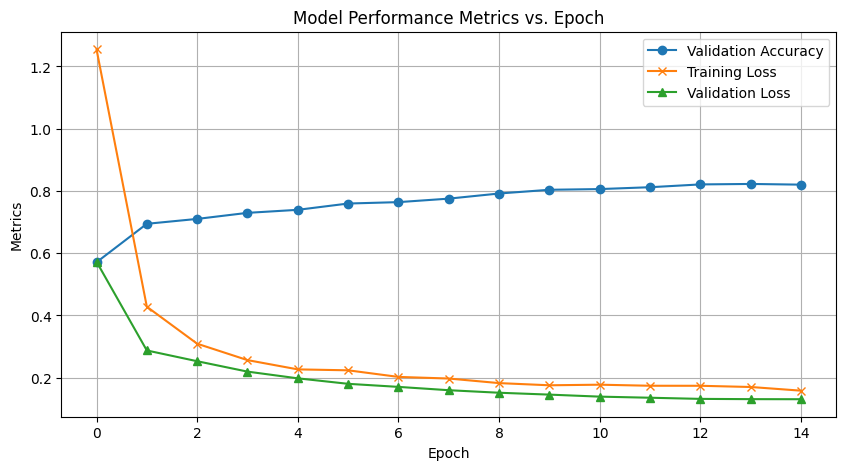

time: 342 ms (started: 2023-12-16 20:44:25 +00:00)


In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(acc, marker='o', label='Validation Accuracy')
plt.plot(train_loss, marker='x', label='Training Loss')
plt.plot(val_loss, marker='^', label='Validation Loss')
plt.legend()

plt.title('Model Performance Metrics vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.grid(True)
plt.show()

In [50]:
# Testing finetuned distil bert
test_dataset = tokenized_datasets["test"]

# Use the trainer to evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print the evaluation results
print(results)

{'eval_loss': 0.0935065895318985, 'eval_accuracy': 0.847331583552056, 'eval_runtime': 18.9488, 'eval_samples_per_second': 12.877, 'eval_steps_per_second': 12.877, 'epoch': 15.0}
time: 19.2 s (started: 2023-12-16 20:44:26 +00:00)


## Observing model outputs

In [51]:
from transformers import pipeline # pipeline automates the tokenization

# Load the model from the Hugging Face Hub
model_schema_tagger = pipeline(model="epolat/t5_finetuned-dbtag-value-part")


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


time: 5.04 s (started: 2023-12-16 20:44:45 +00:00)


The following two methods give the same result

In [77]:
i = 16

type_tag = all_test_type_tags[i]
min_len = len(type_tag) + 1
max_len = min_len


# example_input = all_train_queries[1]
example_input = all_test_queries[i]
example_input_str = " ".join(example_input)

print(f"query: {all_test_queries[i]}")
example_true_db_tags = all_test_db_tags[i]
print('query column tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str)
print('predicted column tags: ', predicted_outputs[0]["generated_text"])

query: ['find', 'all', 'films', 'in', 'which', 'Rowan', 'Atkinson', 'acted', 'as', 'Mr.', 'Bean', '[TTAG]', 'O', 'O', 'TABLE', 'O', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'VALUE', 'VALUE', '[SEP]', 'aid', 'birth_year', 'birth_city', 'name', 'msid', 'role', 'nationality', 'id', 'gender']
query column tags:  ['O', 'O', 'O', 'O', 'O', 'name', 'name', 'O', 'O', 'role', 'role']
predicted column tags:  O O O O O O name name O O gender
time: 248 ms (started: 2023-12-16 20:50:10 +00:00)


In [53]:
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32102, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32102, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

time: 6.76 ms (started: 2023-12-16 20:44:50 +00:00)


In [54]:
i = 107

type_tag = all_test_type_tags[i]
min_len = len(type_tag) + 1
max_len = min_len

text = " ".join(all_test_queries[i])
print(text)
inputs = tokenizer(text, truncation=True, return_tensors="pt").to('cuda')
output = model.generate(**inputs, num_beams=min_len, do_sample=False, early_stopping=False, min_length=min_len,
                        max_length=max_len)

decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)


print(f"true tags: {all_test_db_tags[i]}")
print(f"output: {decoded_output}")

Multiuser Receiver for Decision Feedback [TTAG] VALUE VALUE O VALUE VALUE [SEP] keyphraseid keyphrasename
true tags: ['keyphrasename', 'keyphrasename', 'O', 'keyphrasename', 'keyphrasename']
output: ['keyphrasename keyphrase']
time: 374 ms (started: 2023-12-16 20:44:50 +00:00)


In [55]:
text = "What are the invoice dates for customers with the first name Astrid and the last name Gruber?"
print(text)
inputs = tokenizer(text, truncation=True, return_tensors="pt").to('cuda')
output = model.generate(**inputs, num_beams=min_len, do_sample=False, early_stopping=False)

decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)

print(f"output: {decoded_output}")

What are the invoice dates for customers with the first name Astrid and the last name Gruber?
output: ['What are invoice dates for customers with the first name Astrid and the last name Gruber']
time: 200 ms (started: 2023-12-16 20:44:51 +00:00)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [56]:
total_pred = 0
correct_pred = 0
for idx, test_query in enumerate(all_test_queries):
  test_query_concat = " ".join(test_query)
  test_query_true_db_tags = all_test_db_tags[idx]
  test_query_type_tags = all_test_type_tags[idx]
  min_len = len(test_query_type_tags)
  max_len = min_len + 1
  predicted_db_tags = model_schema_tagger(test_query_concat, min_length=min_len, max_length=max_len)

  predicted_db_tags = predicted_db_tags[0]["generated_text"].split(" ")

  for i, pred_db_tag in enumerate(predicted_db_tags):
    if(test_query_true_db_tags[i].lower() == pred_db_tag.lower()):
      correct_pred += 1

  total_pred += len(predicted_db_tags)

time: 36.6 s (started: 2023-12-16 20:44:51 +00:00)


In [57]:
print(f"accuracy: {correct_pred / total_pred}")

accuracy: 0.8721886999451454
time: 498 µs (started: 2023-12-16 20:45:27 +00:00)


In [58]:
total_pred = 0
correct_pred = 0
for idx, test_query in enumerate(all_test_queries[10]):
  test_query_concat = " ".join(test_query)
  print('test_query_concat: ', test_query_concat)
  test_query_true_db_tags = all_test_db_tags[idx]
  test_query_type_tags = all_test_type_tags[idx]
  min_len = len(test_query_type_tags)
  max_len = min_len + 1
  predicted_db_tags = model_schema_tagger(test_query_concat, min_length=min_len, max_length=max_len)

  predicted_db_tags = predicted_db_tags[0]["generated_text"].split(" ")

  for i, pred_db_tag in enumerate(predicted_db_tags):
    if(test_query_true_db_tags[i].lower() == pred_db_tag.lower()):
      correct_pred += 1

  total_pred += len(predicted_db_tags)

test_query_concat:  F i n d
test_query_concat:  a l l
test_query_concat:  m o v i e s
test_query_concat:  f e a t u r i n g
test_query_concat:  K a t e
test_query_concat:  W i n s l e t
test_query_concat:  [ T T A G ]
test_query_concat:  O
test_query_concat:  O
test_query_concat:  T A B L E
test_query_concat:  T A B L E R E F
test_query_concat:  V A L U E
test_query_concat:  V A L U E
test_query_concat:  [ S E P ]
test_query_concat:  a i d
test_query_concat:  b i r t h _ y e a r
test_query_concat:  b i r t h _ c i t y
test_query_concat:  n a m e
test_query_concat:  n a t i o n a l i t y
test_query_concat:  g e n d e r
time: 2.64 s (started: 2023-12-16 20:45:27 +00:00)


In [59]:
test_query_concat = "How many heads of the departments are older than 56 ? [TTAG] O O ATTR O O 0 O 0 O VALUE O [SEP] department_id name creation ranking budget_in_billions num_employees"
test_query_true_db_tags = all_test_db_tags[0]
test_query_type_tags = all_test_type_tags[0]
min_len = len(test_query_type_tags)
max_len = min_len + 1

predicted_col_tags = model_schema_tagger(test_query_concat)
predicted_col_tags = predicted_col_tags[0]["generated_text"].split(" ")
print(predicted_col_tags)

predicted_col_tags = model_schema_tagger(test_query_concat, min_length=min_len, max_length=max_len)
predicted_col_tags = predicted_col_tags[0]["generated_text"].split(" ")
print(predicted_col_tags)


['O', 'O', 'department_id', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'department_id', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
time: 487 ms (started: 2023-12-16 20:45:30 +00:00)


time: 493 ms (started: 2023-12-16 20:45:30 +00:00)
